In [1]:
import os 
from datetime import datetime 

import folium
from folium import plugins
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
test_set_size = 0.2
val_set_size = 0.25
n_folds = 5
scoring = 'accuracy'
seed = 120
n_jobs = 1

In [3]:
raw = pd.read_json("data/raw.json", lines=True)

In [4]:
raw.head()

,property_type,total_floor_area,number_habitable_rooms,number_heated_rooms,estimated_min_price,estimated_max_price,latitude,longitude,bedrooms
0,Flats/Maisonettes,39.0,1,1,103000,126000,52.164661,-1.856154,0
1,Flats/Maisonettes,24.0,1,1,36000,44000,52.523281,-2.054445,0
2,Flats/Maisonettes,25.0,1,1,187000,229000,51.386343,-0.108323,0
3,Flats/Maisonettes,27.0,1,1,234000,350000,51.416946,-0.151787,2
4,Flats/Maisonettes,29.0,1,1,185000,277000,52.915728,-1.475258,1


In [5]:
raw.describe()

,total_floor_area,number_habitable_rooms,number_heated_rooms,estimated_min_price,estimated_max_price,latitude,longitude,bedrooms
count,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000
mean,95.110280,4.731386,4.644062,3.258840e+05,3.768346e+05,52.341382,-1.304311,2.869454
std,77.209212,1.662938,1.677080,2.946820e+05,3.555607e+05,1.130432,1.298806,0.978529
min,0.000000,1.000000,0.000000,1.000000e+04,1.500000e+04,49.912711,-6.312345,0.000000
25%,68.812750,4.000000,4.000000,1.670000e+05,1.920000e+05,51.460908,-2.187931,2.000000
50%,85.000000,5.000000,5.000000,2.560000e+05,2.930000e+05,52.093607,-1.328639,3.000000
75%,108.000000,6.000000,5.000000,3.920000e+05,4.490000e+05,53.359308,-0.251483,3.000000
max,60506.700000,83.000000,83.000000,1.906000e+07,2.858000e+07,55.879634,1.757928,9.000000


In [6]:
raw.dtypes

property_type              object
total_floor_area          float64
number_habitable_rooms      int64
number_heated_rooms         int64
estimated_min_price         int64
estimated_max_price         int64
latitude                  float64
longitude                 float64
bedrooms                    int64
dtype: object

In [7]:
## Expensive Function Warning!!
# we will be seeing this map again later :D 

smaller_df = raw.sample(n=1000)

# Create a map using the Map() function and the coordinates for Boulder, CO
m = folium.Map(location=[smaller_df.latitude.mean(), smaller_df.longitude.mean()])

for row in smaller_df.itertuples():
        # Add marker for Boulder, CO
        folium.Marker(
            location=[row.latitude, row.longitude], # coordinates for the marker (Earth Lab at CU Boulder)
            popup=f"{row.property_type} with {row.bedrooms} costing {row.estimated_min_price}-{row.estimated_max_price}", # pop-up label for the marker
            icon=folium.Icon()
        ).add_to(m)

# Display the map
m

### Check for any missing values
(not that i think your ETL pipelines are bad ;))

In [8]:
raw.isnull().sum()

property_type             0
total_floor_area          0
number_habitable_rooms    0
number_heated_rooms       0
estimated_min_price       0
estimated_max_price       0
latitude                  0
longitude                 0
bedrooms                  0
dtype: int64

No missing data imputation required

In [9]:
raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   property_type           1000000 non-null  object 
 1   total_floor_area        1000000 non-null  float64
 2   number_habitable_rooms  1000000 non-null  int64  
 3   number_heated_rooms     1000000 non-null  int64  
 4   estimated_min_price     1000000 non-null  int64  
 5   estimated_max_price     1000000 non-null  int64  
 6   latitude                1000000 non-null  float64
 7   longitude               1000000 non-null  float64
 8   bedrooms                1000000 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 68.7+ MB


In [10]:
columns = len(raw.columns)
attributes = columns - 1

target_variable = columns

### Split into Attributes and Target Variable

In [11]:
X_raw = raw.iloc[:, 0:attributes]
y_raw = raw.iloc[:, attributes]

In [12]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
display_columns = 4
if attributes % display_columns == 0 :
    display_rows = attributes // display_columns
else :
    display_rows = (attributes // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns*4
fig_size[1] = display_rows*4
plt.rcParams["figure.figsize"] = fig_size

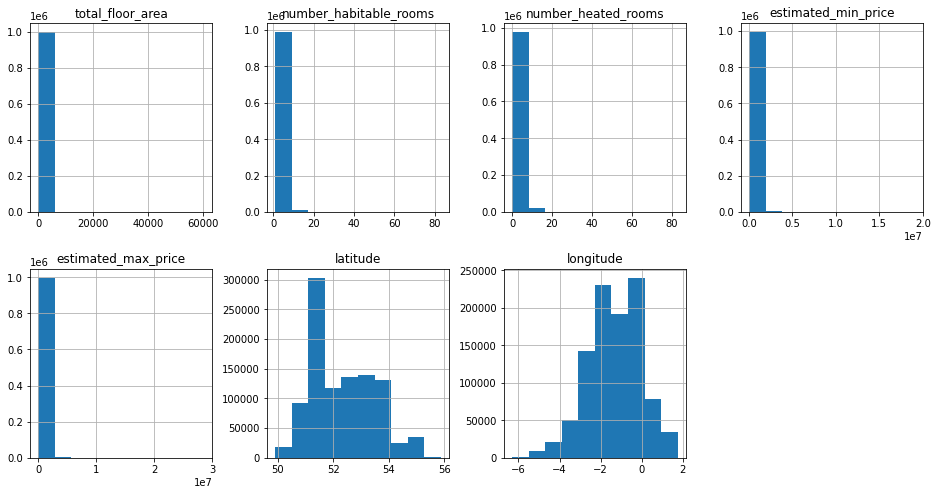

In [13]:
X_raw.hist(layout=(display_rows, display_columns))
plt.show()

The histograms are largely useless due to 1 or 2 extreme values
- might be worth removing them for the core of modelling, further investigation required
- they may well represent a higher end

Latitude and longitude are interesting
- suggests homes are from across the country, could be interesting as a binned variable, or continous

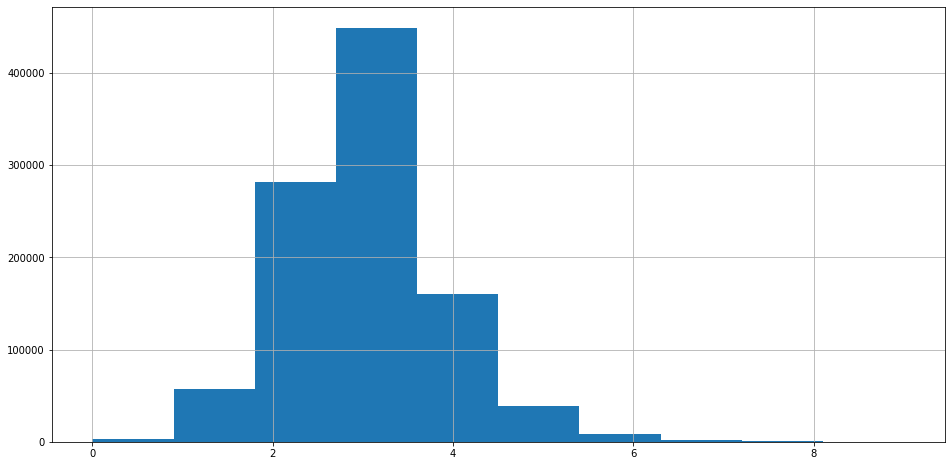

In [14]:
y_raw.hist()
plt.show()

The target variable poses a very normal histogram, at first I questioned if 0 meant missing, but the scarcity suggests 0 = studio.

But this poses the problem that the dataset is very imbalanced - SMOTE maybe required


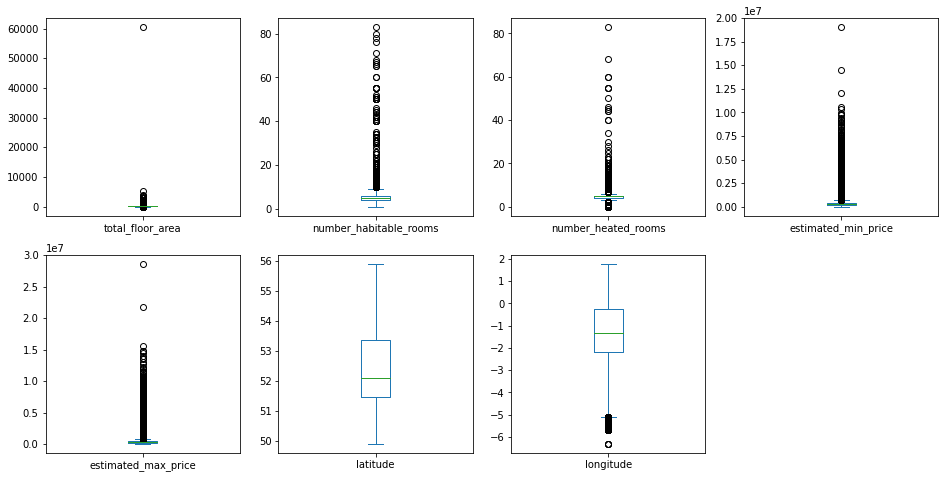

In [15]:
X_raw.plot(kind='box', subplots=True, layout=(display_rows,display_columns))
plt.show()

These box plots tell the story that histograms do not
- the mean of the distributions are clear
- the IQR of most distributions are very good
- some have _very_ heavy upper tails, potentially demonstrating the high end property market
- there is 1 property with a far larger amount of floor space than anything else - this must be checked
- there are several properties beyond -5 longitude, potentially northern ireland or scotland - these must be checked for validity

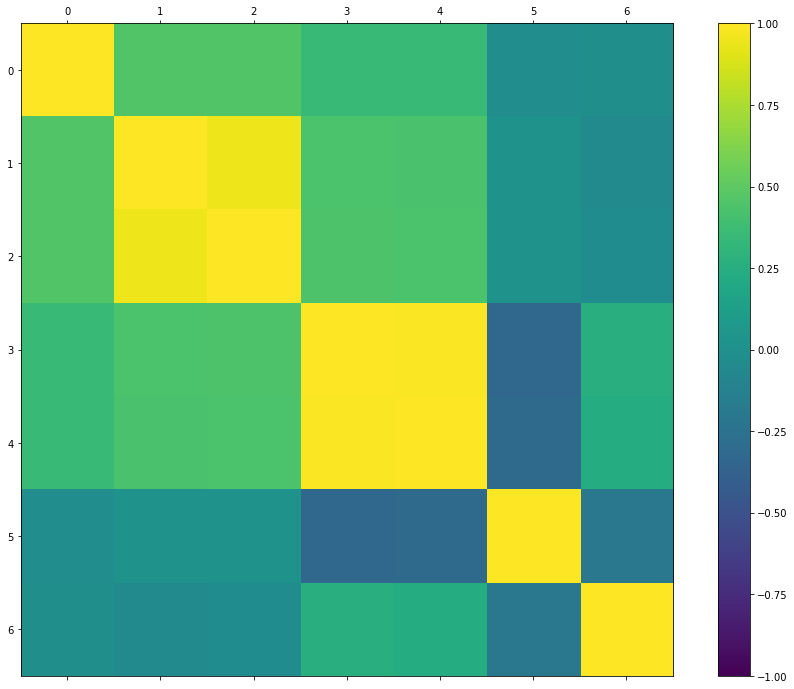

In [16]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_raw.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

The correlation of variables is fantastic really.
Most variables are between 0.5 and -0.5, which will hopefully lead to a strong model
- quite obviously the estimated lower and estimated upper are strongly positively correlated
- as is the number of habitable rooms and heated rooms being strongly positively correlated

### Splitting the Dataset

In [17]:
X_train_val, X_test_df, y_train_val, y_test_df = train_test_split(X_raw, y_raw, test_size=test_set_size, stratify=y_raw, random_state=seed)
X_train_df, X_validation_df, y_train_df, y_validation_df = train_test_split(X_train_val, y_train_val, test_size=val_set_size, stratify=y_train_val, random_state=seed)

Splitting the dataset into test, train and validation sets to perform various performance analysis
- stratify is used to ensure that no class (bedrooms) is under-represented in the splits
- the seed is set to make results reproducible

The dataset is split into 3 parts
- train size is 60%
- test is 20%
- validation is 20%

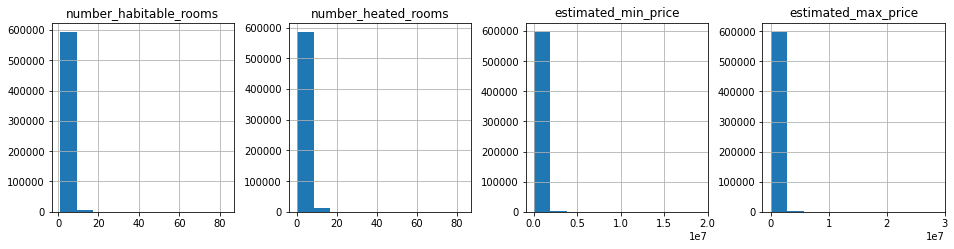

In [18]:
# Histograms for each attribute before pre-processing
columns_to_scale = X_train_df.columns[X_train_df.dtypes == 'int64'].tolist()
X_train_df[columns_to_scale].hist(layout=(display_rows,display_columns))
plt.show()

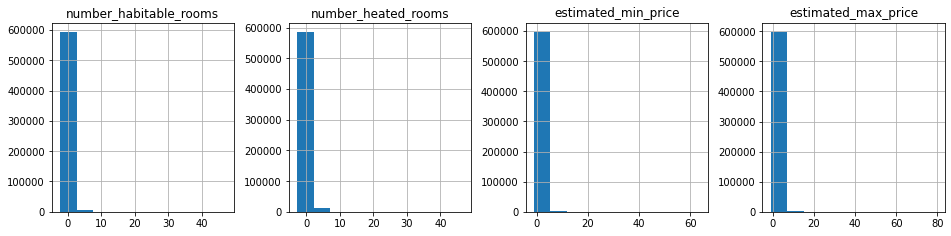

In [19]:
scaler = preprocessing.StandardScaler()
X_train_df[columns_to_scale] = scaler.fit_transform(X_train_df[columns_to_scale])
X_train_df[columns_to_scale].hist(layout=(display_rows,display_columns))
plt.show()

# also do validation set
X_validation_df[columns_to_scale] = scaler.fit_transform(X_validation_df[columns_to_scale])

In [20]:
# # Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = X_train_df.select_dtypes(include=['int64','uint8','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])
categorical_columns = X_train_df.select_dtypes(include=['object','bool']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [21]:
# # Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training datasets for final inspection
X_train = preprocessor.fit_transform(X_train_df)
y_train = y_train_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

# Display the shapes of the training datasets for final inspection
X_validation = preprocessor.fit_transform(X_validation_df)
y_validation = y_validation_df.ravel()
print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))


X_train.shape: (600000, 11) y_train.shape: (600000,)
X_validation.shape: (200000, 11) y_validation.shape: (200000,)


In [22]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()

train_models = []
train_results = []
train_model_names = []
train_metrics = []

train_models.append(('LDA', LinearDiscriminantAnalysis()))
train_models.append(('CART', DecisionTreeClassifier(random_state=seed)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BGT', BaggingClassifier(random_state=seed, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seed, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=seed, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingClassifier(random_state=seed)))

In [ ]:
# Generate model in turn
for name, model in train_models:
    start_time_model = datetime.now()
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_model), '\n')
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LDA: 0.636150 (0.001385)
LinearDiscriminantAnalysis()
Model training time: 0:00:03.310198 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CART: 0.662492 (0.000936)
DecisionTreeClassifier(random_state=120)
Model training time: 0:00:22.415037 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN: 0.738127 (0.000426)
KNeighborsClassifier(n_jobs=1)
Model training time: 0:01:41.798887 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.735818 (0.000838)
BaggingClassifier(n_jobs=1, random_state=120)
Model training time: 0:02:32.065158 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 0.755810 (0.001093)
RandomForestClassifier(n_jobs=1, random_state=120)
Model training time: 0:08:57.732531 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


EXT: 0.752975 (0.001123)
ExtraTreesClassifier(n_jobs=1, random_state=120)
Model training time: 0:04:53.768394 



## Results Talk

The methods tested increase in training time and complexity (and also accuracy)

- LDA and CART are very simplistic yielding 0.63 (0.001) and 0.66 (0.0009) score respectively.
- Improving on these KNN and BGT yield 0.73 (0.0004, 0.008), a respectable increase at the cost of training time.
- RNF produces again increased, but with increased variablity 0.755 (0.001) but takes 9 minutes to train.
- EXT adds more randomness, and leads to worse overall accuracy 0.752 (0.001) but requires half the time of RNF.
- GBM doesnt add much value

In [ ]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [ ]:
# Set up the comparison array
tune_results = []
tune_model_names = []


# Tuning algorithm #1 - Extra Trees
start_time_model = datetime.now()

tune_model_1 = ExtraTreesClassifier(random_state=seed, n_jobs=n_jobs)
tune_model_names.append('EXT')
param_grid_1 = dict(n_estimators=np.array([10, 50, 100, 150, 200]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
grid_1 = GridSearchCV(estimator=tune_model_1, param_grid=param_grid_1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result_1 = grid_1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result_1.best_score_, grid_result_1.best_params_))
tune_results.append(grid_result_1.cv_results_['mean_test_score'])
means = grid_result_1.cv_results_['mean_test_score']
stds = grid_result_1.cv_results_['std_test_score']
params = grid_result_1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_model))

In [ ]:
best_param_key_1 = list(grid_result_1.best_params_.keys())[0]
best_param_value_1 = list(grid_result_1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_param_key_1, '=', best_param_value_1)

In [ ]:
# Tuning algorithm #1 - Extra Trees
start_time_model = datetime.now()

tune_model_2 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('RNF')
param_grid_2 = dict(n_estimators=np.array([10, 50, 100, 150, 200]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
grid_2 = GridSearchCV(estimator=tune_model_2, param_grid=param_grid_2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result_2 = grid_2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result_2.best_score_, grid_result_2.best_params_))
tune_results.append(grid_result_2.cv_results_['mean_test_score'])
means = grid_result_2.cv_results_['mean_test_score']
stds = grid_result_2.cv_results_['std_test_score']
params = grid_result_2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_model))

In [ ]:
best_param_key_2 = list(grid_result_2.best_params_.keys())[0]
best_param_value_2 = list(grid_result_2.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_param_key_2, '=', best_param_value_2)

In [ ]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [ ]:
validation_model_1 = ExtraTreesClassifier(n_estimators=best_param_value_1, random_state=seed, n_jobs=n_jobs)
validation_model_1.fit(X_train, y_train)
print(validation_model_1)
predictions_1 = validation_model_1.predict(X_validation)
print('Accuracy Score:', accuracy_score(y_validation, predictions_1))
print(confusion_matrix(y_validation, predictions_1))
print(classification_report(y_validation, predictions_1))

In [ ]:
validation_model_2 = RandomForestClassifier(n_estimators=best_param_value_2, random_state=seed, n_jobs=n_jobs)
validation_model_2.fit(X_train, y_train)
print(validation_model_2)
predictions_2 = validation_model2.predict(X_validation)
print('Accuracy Score:', accuracy_score(y_validation, predictions_2))
print(confusion_matrix(y_validation, predictions_2))
print(classification_report(y_validation, predictions_2))

In [ ]:
## Create the Final model

In [ ]:
# Combining the training and validation datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_validation))
y_complete = np.concatenate((y_train, y_validation))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
test_model = validation_model_2.fit(X_complete, y_complete)
print(test_model)

In [ ]:
# Apply feature scaling and transformation to the test dataset
scaled_features = scaler.transform(X_test_df[columns_to_scale])
X_test_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_test_df.head())

In [ ]:
# Finalize the test dataset for the modeling testing
X_test = X_test_df.to_numpy()
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

In [ ]:
test_predictions = test_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))